In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import dg_comment as dg

graphs = 'figures/'
savefig = False # set to True to save figures in directory above

T = 500
r = dg.calib_all['r']

In [2]:
# plotting options
plt.rcParams["figure.dpi"] = 200
plt.rc('font', size=14)
plt.rcParams['legend.fontsize'] = 16

# set font to palatino using latex to get exact formatting in comment
# comment out for general audience in case they don't have latex, etc.
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', serif='palatino')

# 1a. MPCs and expected MPCs
We use expectation functions to obtain the expected consumption function at any horizon, and then take numerical first differences to get MPCs:

In [3]:
Tshort = 11
E = dg.expectation_functions(dg.ss2, 'c', Tshort)
ss = dg.ss2.internals['hh']
Empc = np.empty_like(E)
for t in range(Tshort):
    Empc[t] = dg.get_mpcs(E[t], ss['a'], ss['a_grid'], r, forward=(t>0))

mpc_ha_impact = Empc[0].ravel()

q = (1+r)**(-np.arange(Tshort))
mpc_ha_cumul = q @ Empc.reshape(Tshort, -1)
D_ha = ss['D'].ravel()

In [4]:
mpc_ra_impact = r/(1+r)
mpc_ra_cumul = mpc_ra_impact*q.sum() # representative agent smooths conusmption exactly
mpc_ta_impact = np.array([mpc_ra_impact, 1])
mpc_ta_cumul = np.array([mpc_ra_cumul, 1])
D_ta = np.array([0.7, 0.3])

Construct histogram of impact MPCs:

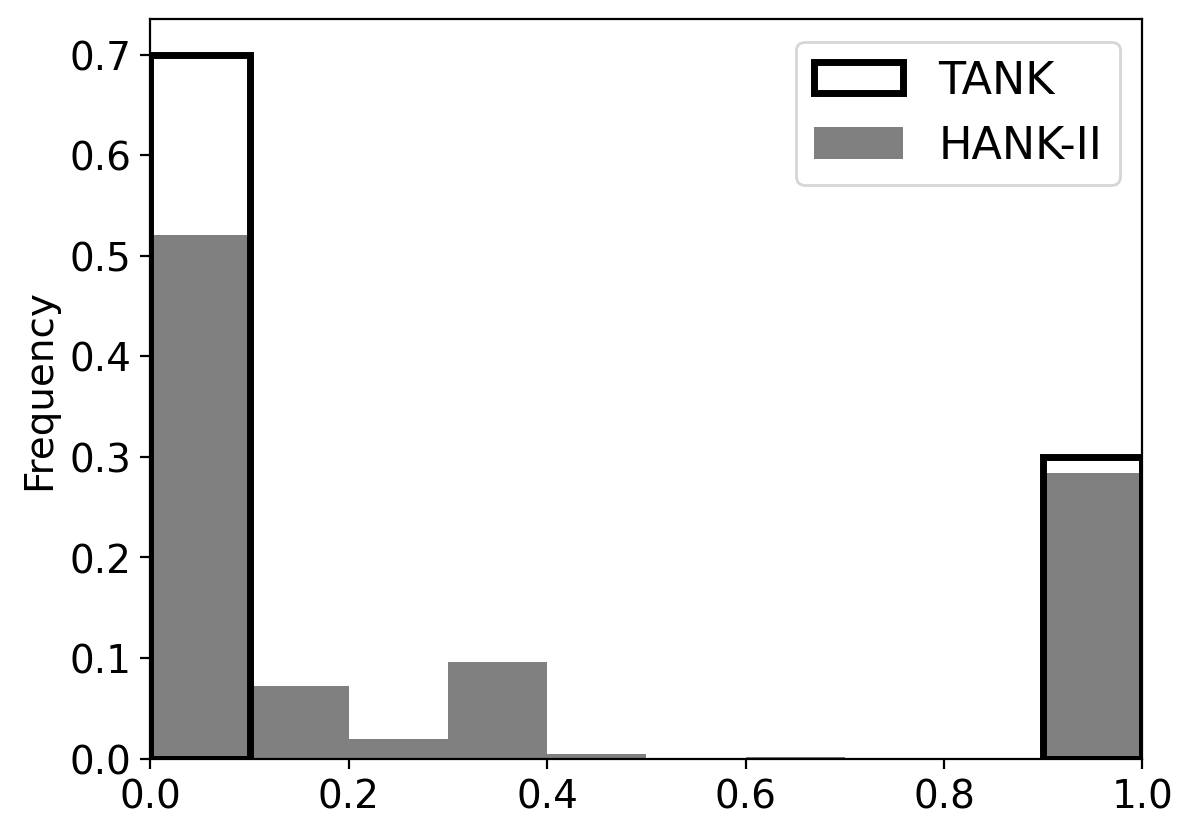

In [5]:
plt.hist(mpc_ha_impact, bins=np.linspace(0, 1, 11), weights=D_ha, facecolor='gray', label='HANK-II');
*_, patches = plt.hist(mpc_ta_impact, bins=np.linspace(0, 1, 11), weights=D_ta, edgecolor='black', linewidth=2.5, facecolor='none', label='TANK');
for i, patch in enumerate(patches):
    if 0 < i < 9:
        plt.setp(patch, 'edgecolor', 'none')
plt.ylabel('Frequency')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.xlim(0, 1)
if savefig: plt.savefig(graphs+'mpc_impact.pdf', bbox_inches='tight')

Calculate average impact MPC and cumulative MPC:

In [6]:
np.vdot(ss['D'], mpc_ha_impact), mpc_ta_impact @ D_ta # average impact MPC

(0.35822253239277557, 0.3034825870646766)

In [7]:
np.vdot(ss['D'], mpc_ha_cumul), mpc_ta_cumul @ D_ta # average cumulative MPC

(0.6911452624958496, 0.3373695935450267)

Also shares of the HANK cumulative MPC in each range:

In [8]:
np.vdot(ss['D'], mpc_ha_cumul < 0.60), np.vdot(ss['D'], mpc_ha_cumul > 0.60)

(0.44364133857681, 0.5563586614231527)

Now make histogram of cumulative MPC:

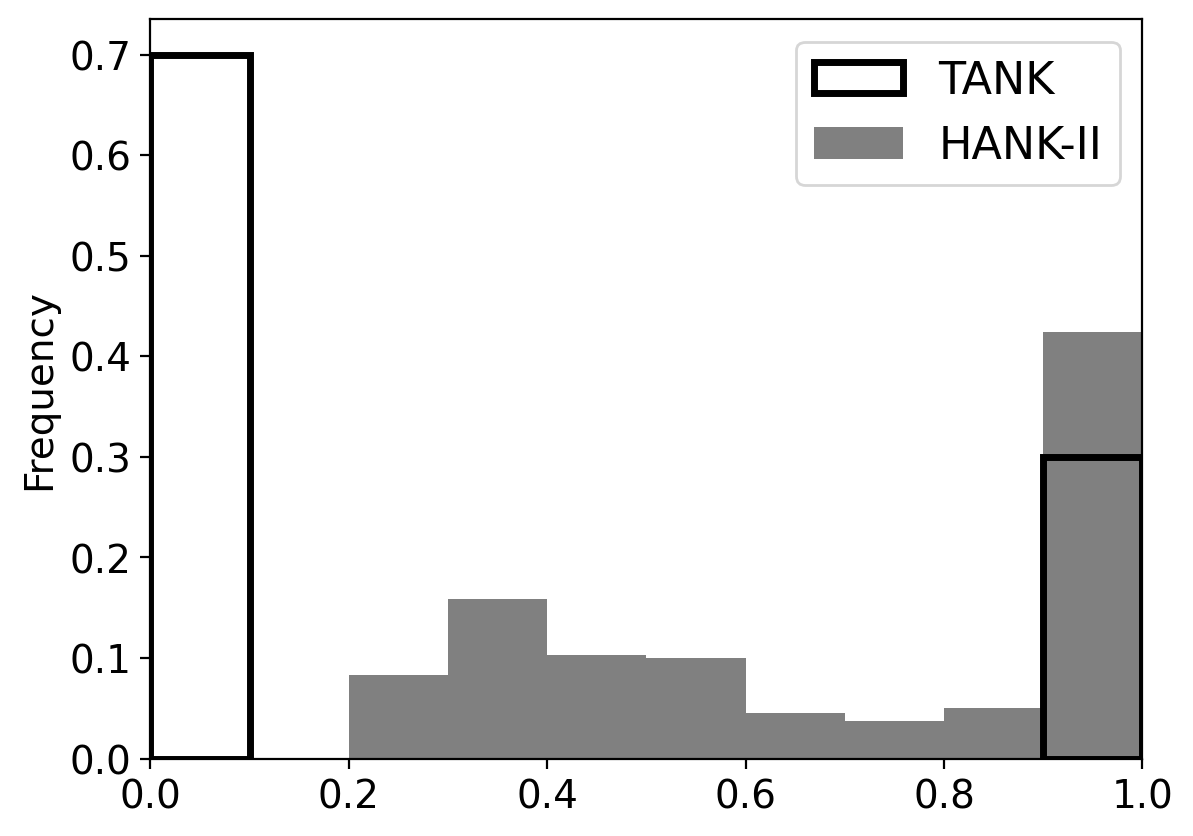

In [9]:
plt.hist(mpc_ha_cumul, bins=np.linspace(0, 1, 11), weights=D_ha, facecolor='gray', label='HANK-II');
*_, patches = plt.hist(mpc_ta_cumul, bins=np.linspace(0, 1, 11), weights=D_ta, edgecolor='black', linewidth=2.5, facecolor='none', label='TANK');
for i, patch in enumerate(patches):
    if 0 < i < 9:
        plt.setp(patch, 'edgecolor', 'none')
plt.ylabel('Frequency')
plt.xlim(0, 1)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
if savefig: plt.savefig(graphs+'mpc_cumul.pdf', bbox_inches='tight')

# 1b. intertemporal MPCs out of transfer and proportional income shocks

### Date-0 transfer shock

For the HA model, we get consumption out of a one-time transfer shock.

In [10]:
dC_HA_uniform = dg.hh.impulse_linear(dg.ss2, {'Tr': 1.*(np.arange(Tshort)==0)}, outputs=['C'])['C']

For RA and TA, we can compute this analytically:

In [11]:
dC_RA = np.full(Tshort, mpc_ra_impact)
dC_TA_uniform = 0.7*dC_RA + 0.3*(np.arange(Tshort)==0)

Plot these:

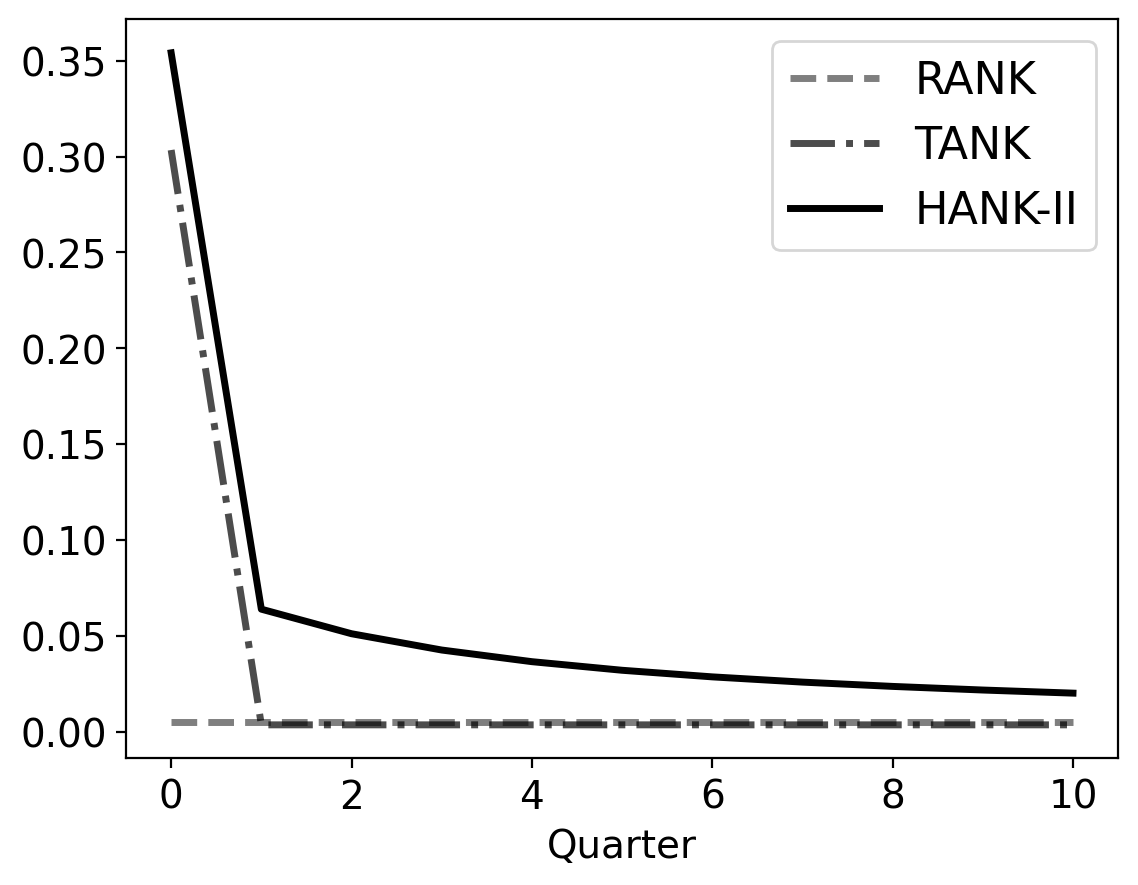

In [12]:
plt.plot(dC_RA, color='black', linestyle='--', linewidth=2.5, label='RANK', alpha=0.5)
plt.plot(dC_TA_uniform, color='black', linestyle='-.', linewidth=2.5, label='TANK', alpha=0.7)
plt.plot(dC_HA_uniform, color='black', linewidth=2.5, label='HANK-II')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs+'impc_uniform.pdf', bbox_inches='tight')

### Date-0 proportional income shock
For het agents, we do this out of a one-time wage shock, which will scale incomes proportionally around the steady state (because steady-state transfers are zero):

In [13]:
HA_results = dg.hh.impulse_linear(dg.ss2, {'w': 1.*(np.arange(Tshort)==0)}, outputs=['C', 'A'])
assert np.isclose(HA_results['C'][0] + HA_results['A'][0], 1) # make sure total wage increase = 1
dC_HA_proportional = HA_results['C']

For TA (TANK-II), we'll note that the hand-to-mouth only have 0.56 of the wage income:

In [14]:
dC_TA_proportional = (1-0.56*0.3)*dC_RA + 0.56*0.3*(np.arange(Tshort)==0)

Calculate cumulative MPCs in the two cases:

In [15]:
q[1:Tshort] @ dC_HA_proportional[1:], q[1:Tshort] @ dC_TA_proportional[1:]

(0.355278411081793, 0.04027712770235901)

Make iMPC plot:

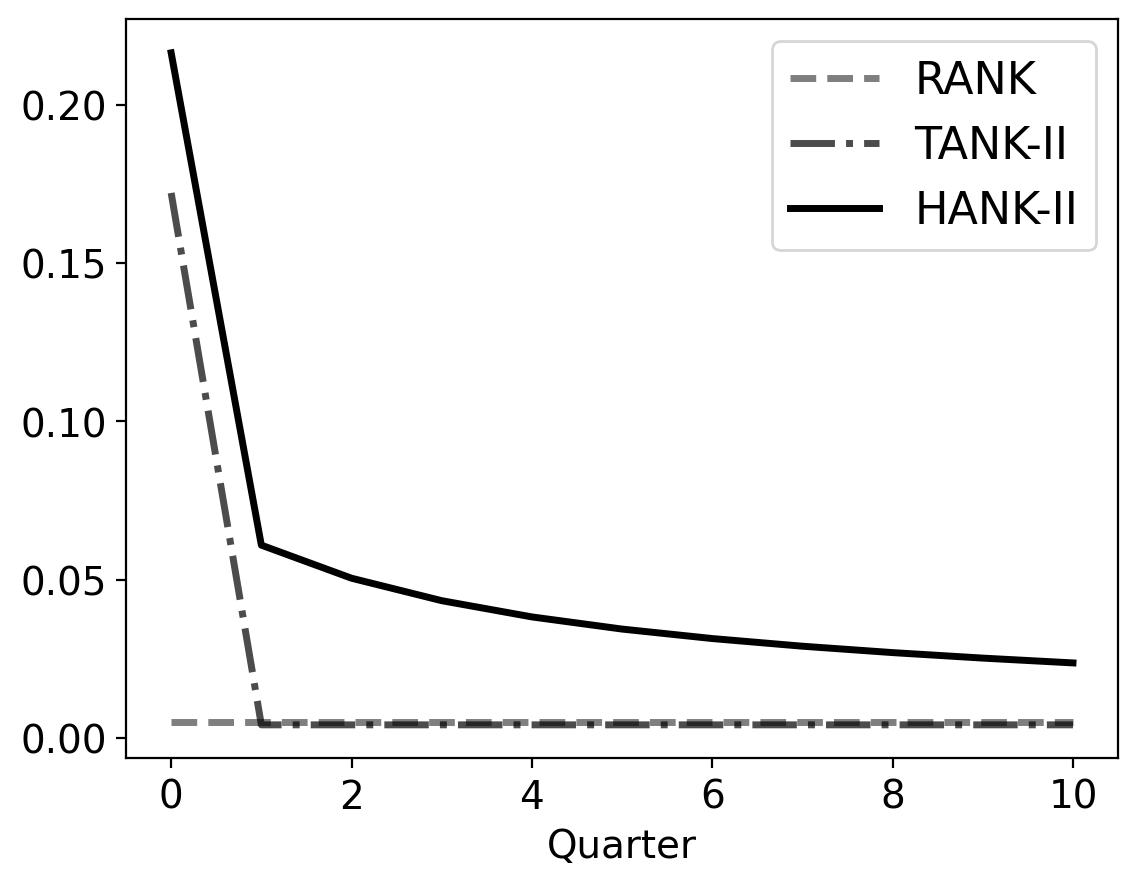

In [16]:
plt.plot(dC_RA, color='black', linestyle='--', linewidth=2.5, label='RANK', alpha=0.5)
plt.plot(dC_TA_proportional, '-.', color='black', label='TANK-II', linewidth=2.5, alpha=0.7)
plt.plot(dC_HA_proportional, color='black', linewidth=2.5, label='HANK-II')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs+'impc_proportional.pdf', bbox_inches='tight')

# Part 2: basic statistics of each model

### 2a. HANK-I model

In [17]:
B_saver, impc_saver, impc_debtor = dg.saver_debtor(dg.ss1, 10)
B_saver / 4, impc_saver[0], impc_debtor[0] # divide by annual total GDP = 4

(3.068607706438002, 0.00727810357270305, 0.0242583783772066)

In [18]:
impc_wage, impc_ave = dg.worker_average(dg.ss1, 10)
impc_wage[0], impc_ave[0]

(0.011576115076630016, 0.014368169896386465)

## 2b. HANK-II model

In [19]:
B_saver, impc_saver, impc_debtor = dg.saver_debtor(dg.ss2, 10)
B_saver / 4, impc_saver[0], impc_debtor[0]

(0.30965796657523725, 0.029228762041148902, 0.5424492209629697)

In [20]:
impc_wage, impc_ave = dg.worker_average(dg.ss2, 10)
impc_wage[0], impc_ave[0] # note: these already visible in plots

(0.21638922110482273, 0.3541972072198299)

# 3. HANK-I analysis, standard monetary shock

Load steady state for HANK-I and Jacobians from support module:

In [21]:
ss1 = dg.get_ss_ge(dg.ss1)
J_HA1 = dg.get_jacobian(ss1, T)
J_RA = dg.get_RA_jacobian(T)

Calculate HANK-I and RANK impulse responses using this, and plot them cumulatively.

In [22]:
dr = -0.25 * 0.5**np.arange(T)
q = (1+r)**(-np.arange(T))
Y_HA1, Y_RA = J_HA1['r'] @ dr, J_RA @ dr
Ycum_HA1, Ycum_RA = (q * Y_HA1).cumsum(), (q * Y_RA).cumsum()
Ycum_HA1[-1], Ycum_RA[-1]

(5.545130211446451, 0.9950495049504949)

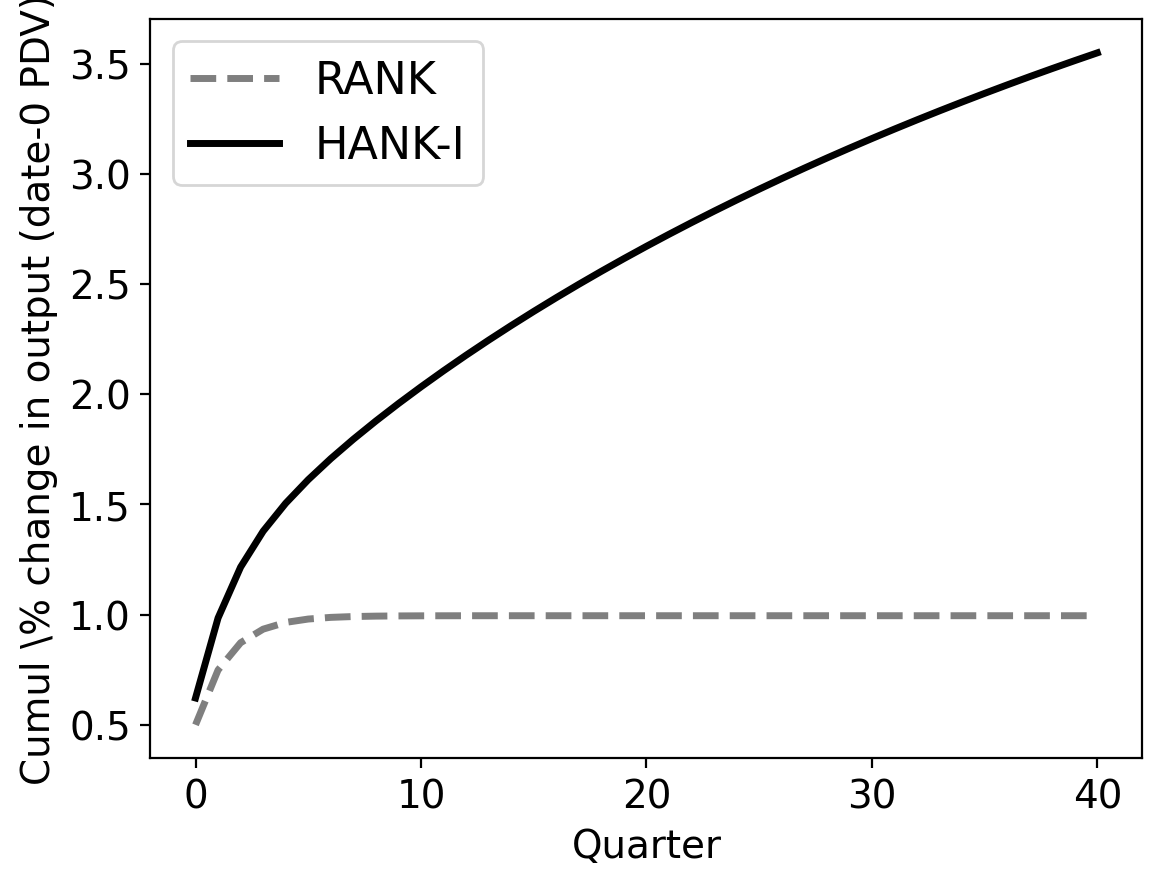

In [23]:
plt.plot(Ycum_RA[:41], '--', color='black', linewidth=2.5, label='RANK', alpha=0.5)
plt.plot(Ycum_HA1[:41], color='black', linewidth=2.5, label='HANK-I')
plt.xlabel('Quarter')
plt.ylabel('Cumul \% change in output (date-0 PDV)')
plt.legend()
if savefig: plt.savefig(graphs + 'hanki-rank-cumulative.pdf', bbox_inches='tight');

Now do "GE decomposition" of impulse responses, applying the separate "rsub" and "rinc" Jacobians calculated in the module to the same shock:

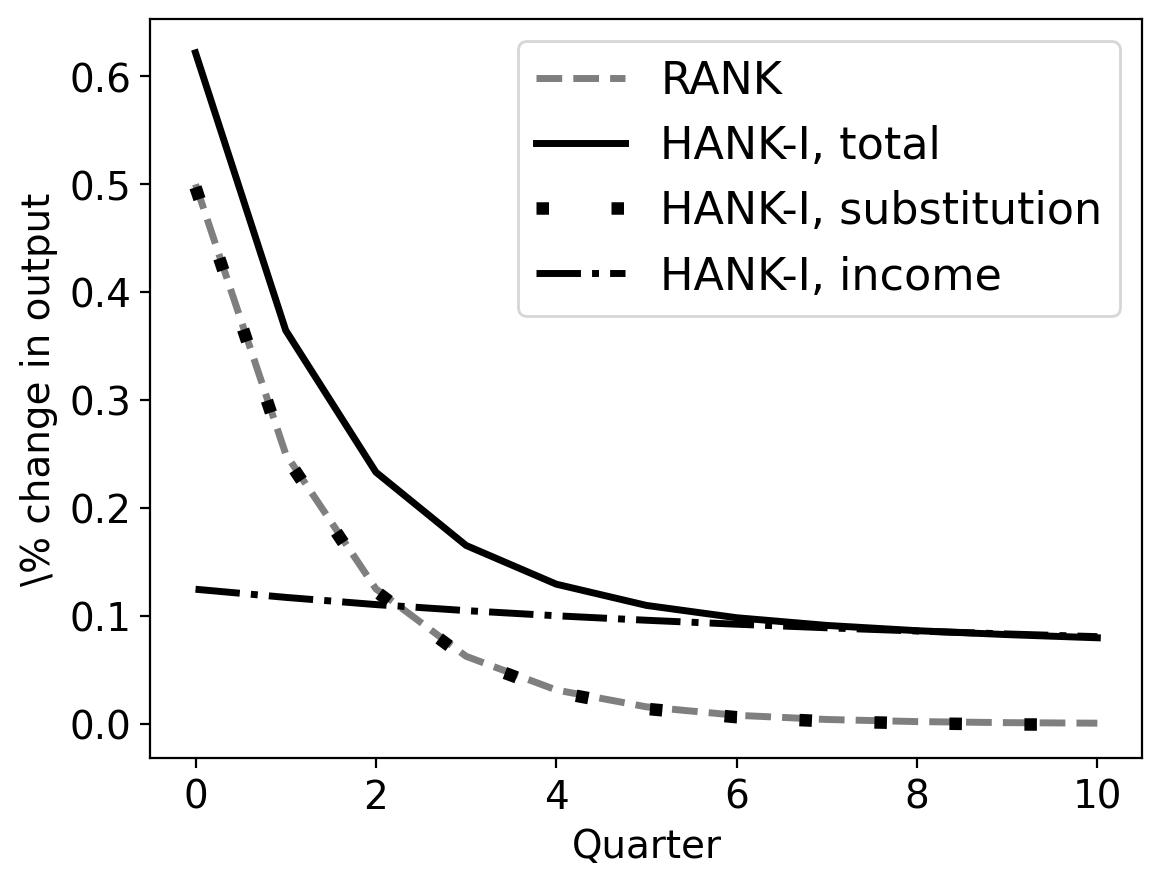

In [24]:
plt.plot((J_RA @ dr)[:11], '--', label='RANK', color='black', linewidth=2.5, alpha=0.5)
plt.plot((J_HA1['r'] @ dr)[:11], label='HANK-I, total', color='black', linewidth=2.5)
plt.plot((J_HA1['rsub'] @ dr)[:11], linestyle=(0, (1, 5)), label='HANK-I, substitution', color='black', linewidth=4.5)
plt.plot((J_HA1['rinc'] @ dr)[:11], '-.', label='HANK-I, income', color='black', linewidth=2.5)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.legend()
if savefig: plt.savefig(graphs + 'hanki-decomposition.pdf', bbox_inches='tight');

# 4. HANK-II, TANK-I, and TANK-II analysis, standard monetary shock

Start by specifying TANK parameters:

In [25]:
# marginal distribution of dollar of income
sigma = 1
varphi = 1
dWN_dY = 1 + sigma + varphi
dDiv_dY = - (sigma + varphi)

# how this determines "multiplier"
lambda_H = 0.3
m_tanki = lambda_H*dWN_dY # in TANK-I, HTM get same wage income, no div income

# now TANK-II parameters
Theta_H = 0.78
Xi_H = 0.56
psi = 2
m_tankii = lambda_H*(Xi_H*dWN_dY + Theta_H*dDiv_dY)

share_u_ss = 1-lambda_H*Xi_H # steady-state consumption share of non-htm in TANK-II

m_tanki, m_tankii

(0.8999999999999999, 0.03600000000000003)

In [26]:
share_u_ss

0.832

What are the coefficients on $d\widehat{R}_t$ and $\frac{dY_t^{RA}}{Y}$?

In [27]:
coeff_rate = 1/(1-m_tankii) * -lambda_H*psi
coeff_RA = 1/(1-m_tankii) * share_u_ss
coeff_rate, coeff_RA

(-0.6224066390041494, 0.8630705394190872)

Now calculate paths for three shocks: baseline monetary shock (replicating the results of the the paper), persistent monetary shock, and forward guidance shock.

In [28]:
ss2 = dg.get_ss_ge(dg.ss2)
J_HA2 = dg.get_jacobian(ss2, T)
J_TA2 = coeff_rate*np.eye(T) + coeff_RA*J_RA

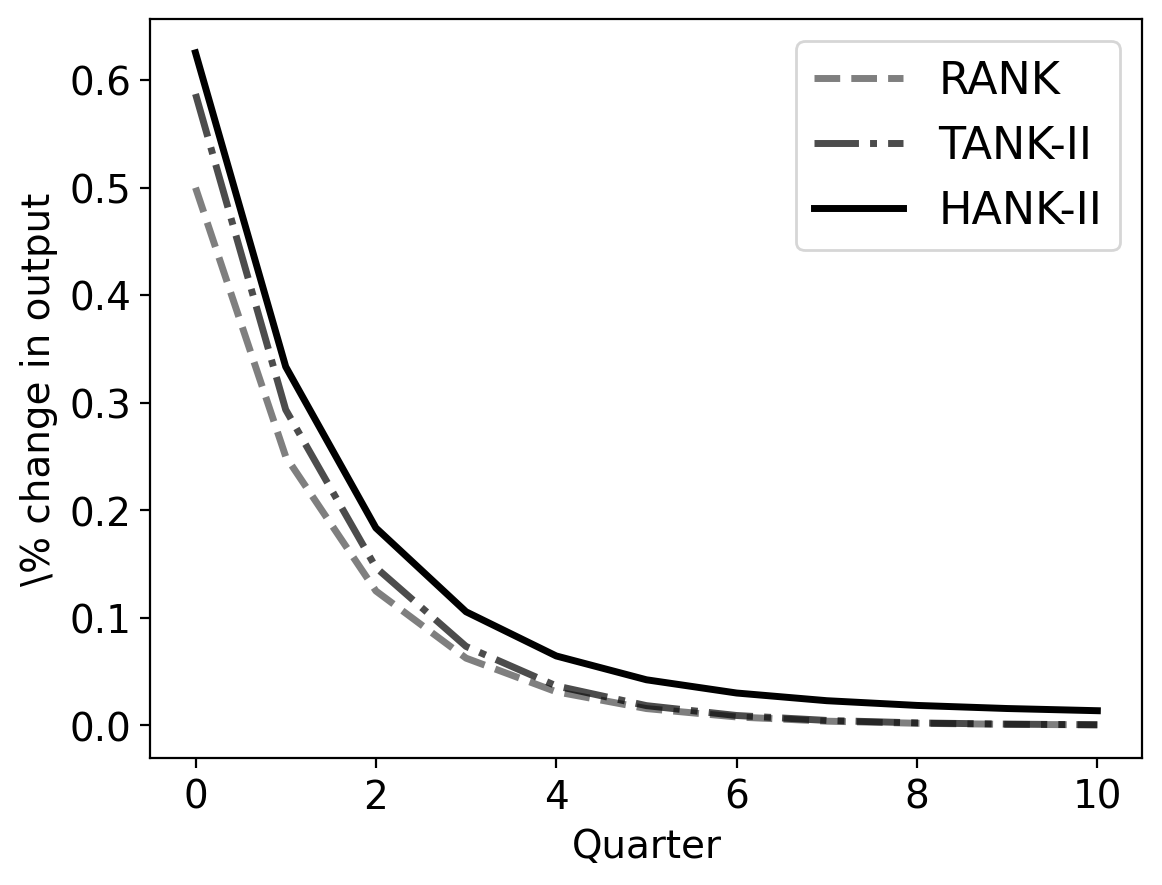

In [29]:
plt.plot((J_RA @ dr)[:11], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5)
plt.plot((J_TA2 @ dr)[:11], '-.', label='TANK-II', color='black', alpha=0.7, linewidth=2.5)
plt.plot((J_HA2['r'] @ dr)[:11], label='HANK-II', color='black', linewidth=2.5)
plt.ylabel('\% change in output')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs + 'baseline_monetary.pdf', bbox_inches='tight');

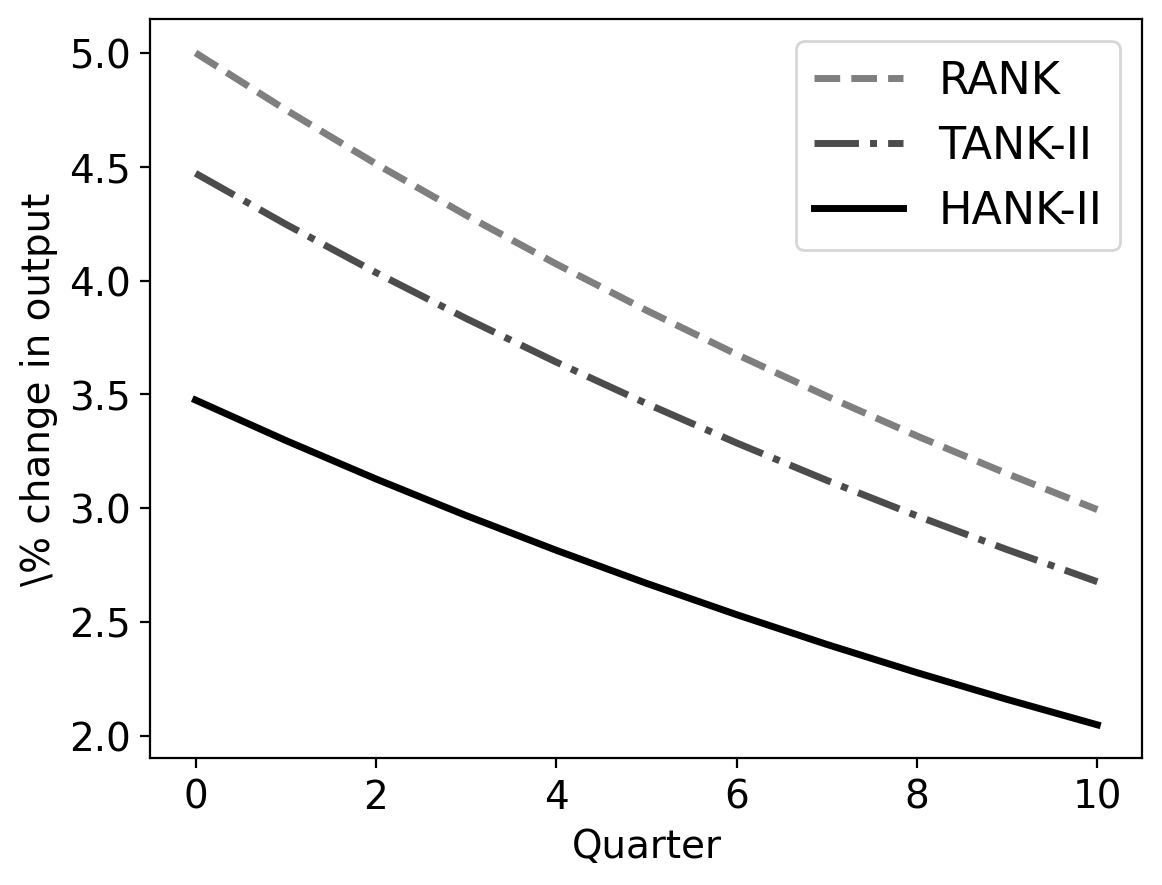

In [30]:
dr = -0.25 * 0.95**np.arange(T)
plt.plot((J_RA @ dr)[:11], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5)
plt.plot((J_TA2 @ dr)[:11], '-.', label='TANK-II', color='black', alpha=0.7, linewidth=2.5)
plt.plot((J_HA2['r'] @ dr)[:11], label='HANK-II', color='black', linewidth=2.5)
plt.legend()
plt.ylabel('\% change in output')
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs + 'persistent_monetary.pdf', bbox_inches='tight');

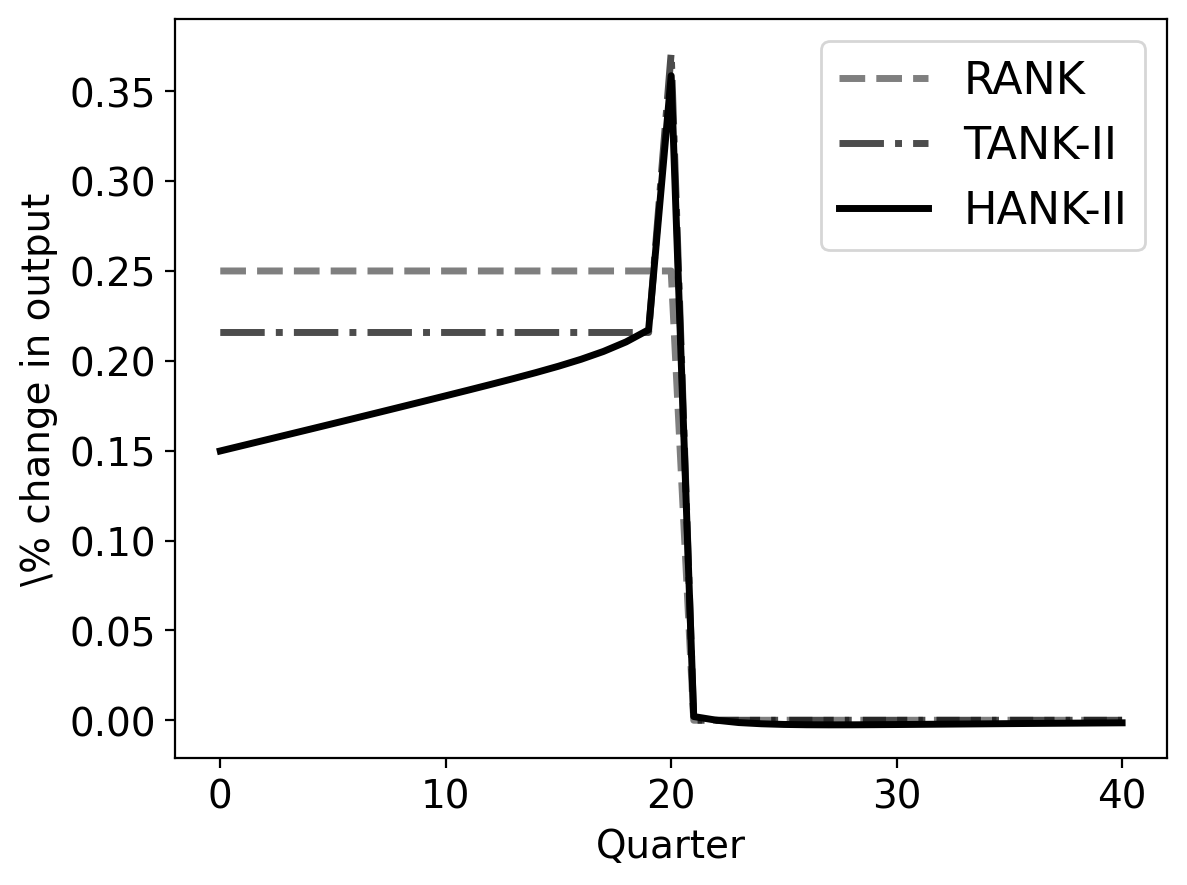

In [31]:
dr = -0.25 *(np.arange(T)==20)
plt.plot((J_RA @ dr)[:41], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5)
plt.plot((J_TA2 @ dr)[:41], '-.', label='TANK-II', color='black', alpha=0.7, linewidth=2.5)
plt.plot((J_HA2['r'] @ dr)[:41], label='HANK-II', color='black', linewidth=2.5)
plt.ylabel('\% change in output')
plt.xlabel('Quarter')
plt.legend()
if savefig: plt.savefig(graphs + 'fg_monetary.pdf', bbox_inches='tight');

# 5. Fiscal policy results

Here we use TANK formulas to get static multipliers on government spending and taxes. These can be derived in parallel to the formulas for monetary policy in equations (1)—(3) in the comment.

Concretely, since government spending affects output (and therefore labor) without affecting consumption, the changes in labor and dividend income now become

$$
\begin{align*}
dW_{t}N_{t}	&=(1+\varphi)dY_{t}+\sigma dC_{t}=(1+\varphi+\sigma)dY_{t}-\sigma dG_{t} \\
dD_{t}	&=-\varphi dY_{t}-\sigma dC_{t}=-(\varphi+\sigma)dY_{t}+\sigma dG_{t}
\end{align*}
$$

Equation (1) in the comment drops the $d\widehat{R}_t$ term, since real interest rates are not not changing, but since incomes directly depend on $dG_t$ above, it picks up a term $\lambda^{H}(\Theta^{H}-\Xi^{H})\sigma dG_{t}$, as well as a taxation term $-\lambda^{H}dT_{t}$.

Then, in general equilibrium, output of course includes the effects of government spending, while the unconstrained agents do not change their consumption (because of the fixed real interest rate path), resulting in a formula of the form

$$
dY_{t}=\frac{1}{1-m}\left(\left(1+\lambda^{H}(\Theta^{H}-\Xi^{H})\sigma\right)dG_{t}-\lambda^{H}dT_{t}\right)
$$

In [32]:
mult_G = 1/(1-m_tankii)*(1+lambda_H*(Theta_H - Xi_H)*sigma)
mult_T = -1/(1-m_tankii)*lambda_H

In [33]:
dG = 0.8**np.arange(T)
dBs = [np.zeros(T), dg.Bplan(dG, 0.9), dg.Bplan(dG, 0.975)]
dTs = [dg.Tplan(dG, dB, r) for dB in dBs]

In [34]:
dYs_TA2 = [mult_G*dG + mult_T*dT for dT in dTs]
dY_TA2_bb, dY_TA2_def_short, dY_TA2_def_long = dYs_TA2

In [35]:
dYs_HA2 = [J_HA2['T'] @ dT + J_HA2['B'] @ dB for dT, dB in zip(dTs, dBs)]
dY_HA2_bb, dY_HA2_def_short, dY_HA2_def_long = dYs_HA2

Calculate impact and cumulative multipliers:

In [36]:
# multipliers: RA, TA, HA (bb, def_short, def_long)
mult_impact = np.array([dY[0].round(2) for dY in [dG]*3+dYs_TA2+dYs_HA2])
mult_cumul = np.array([((q @ dY)/(q @ dG)).round(2) for dY in [dG]*3+dYs_TA2+dYs_HA2])

And summarize them exactly as I do in the table:

In [37]:
arrays = [['RA']*3 + ['TA']*3 + ['HA']*3, ['bb', 'def_brief', 'def_long']*3]
index = pd.MultiIndex.from_arrays(arrays)
df = pd.DataFrame(np.stack((mult_impact, mult_cumul), axis=-1),
                  index=index, columns=['_impact', 'cumul'])
df = df.unstack().T.swaplevel().sort_index()
df[['RA', 'TA', 'HA']]

RA    TA    HA
bb        _impact  1.0  0.79  0.69
          cumul    1.0  0.79  0.59
def_brief _impact  1.0  1.07  1.13
          cumul    1.0  0.79  0.82
def_long  _impact  1.0  1.10  1.36
          cumul    1.0  0.79  2.44

Now make figures:

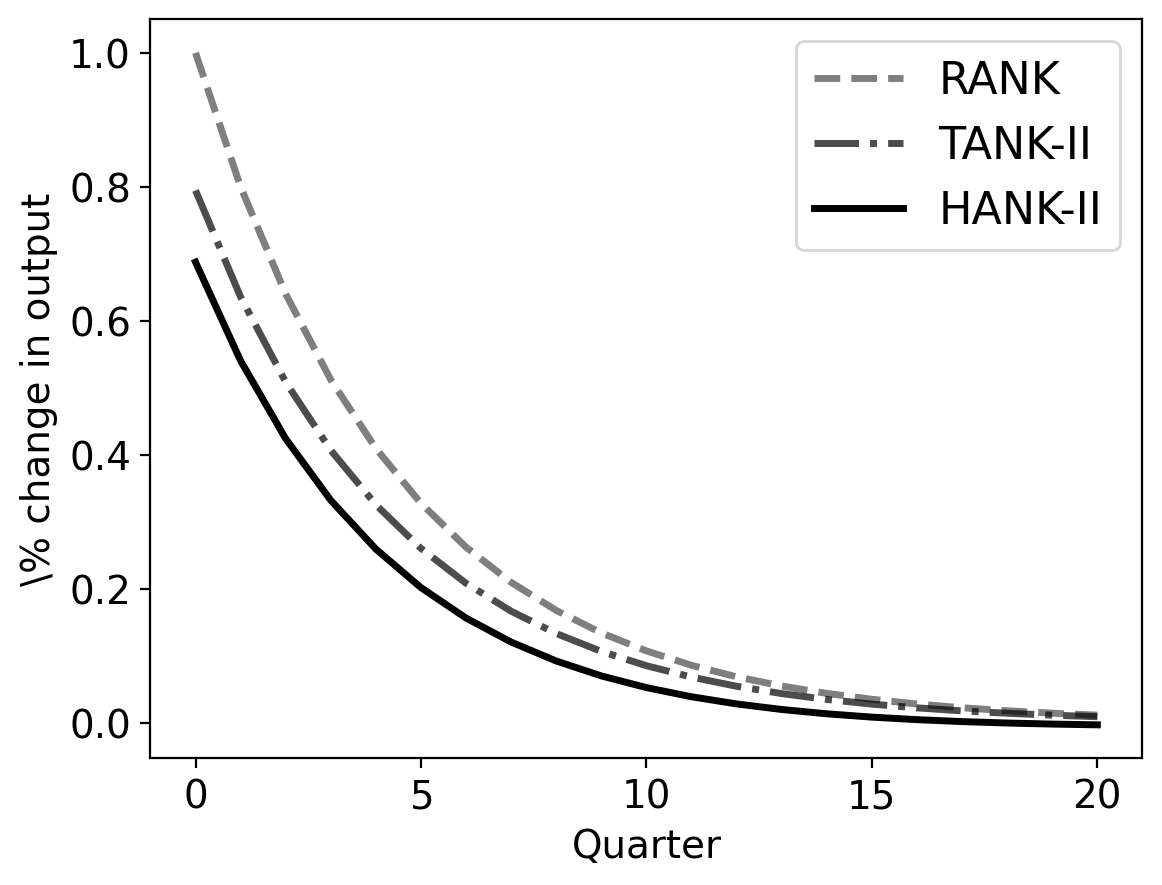

In [38]:
plt.plot(dG[:21], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5)
plt.plot(dY_TA2_bb[:21], '-.', label='TANK-II', color='black', alpha=0.7, linewidth=2.5)
plt.plot(dY_HA2_bb[:21], label='HANK-II', color='black', linewidth=2.5)
plt.ylabel('\% change in output')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs + 'balanced_budget.pdf', bbox_inches='tight');

(This figure replicates the results in the paper but I exclude it from the comment for brevity.)

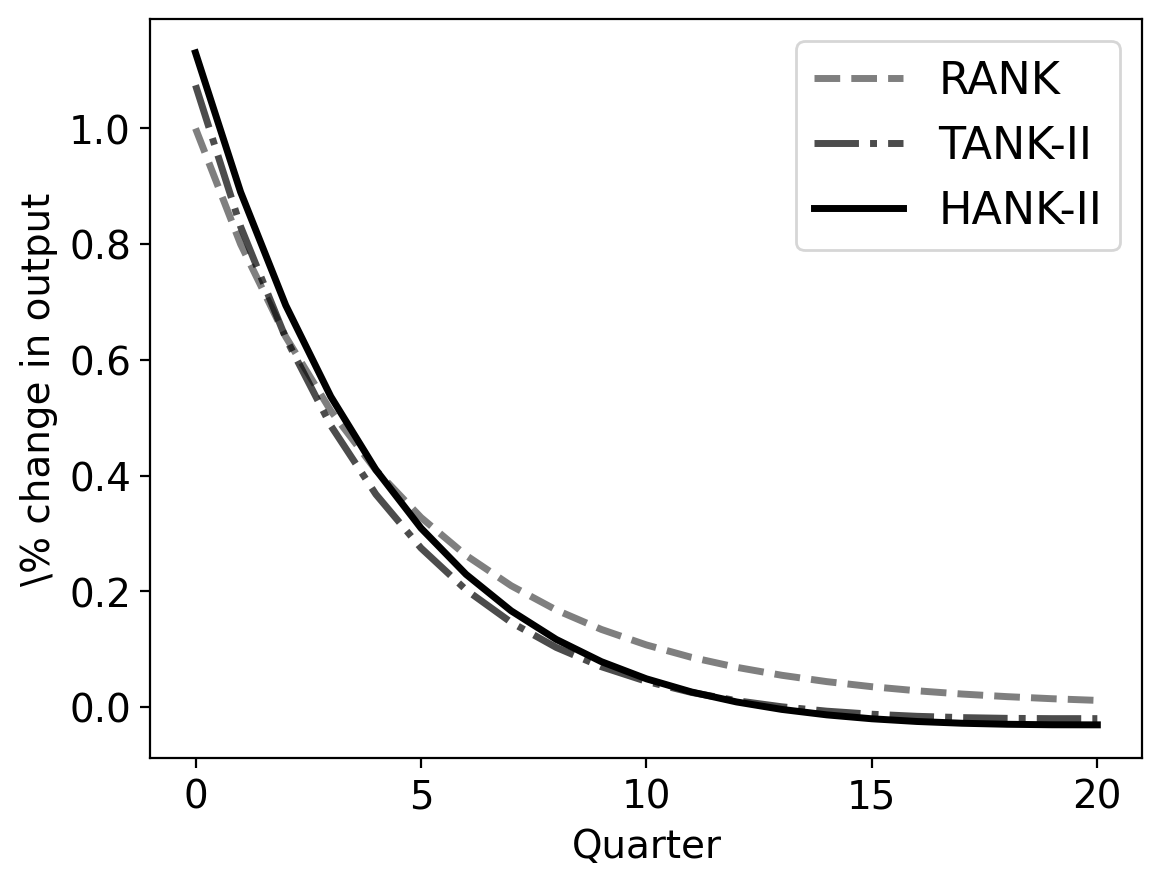

In [39]:
plt.plot(dG[:21], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5)
plt.plot(dY_TA2_def_short[:21], '-.', label='TANK-II', color='black', alpha=0.7, linewidth=2.5)
plt.plot(dY_HA2_def_short[:21], label='HANK-II', color='black', linewidth=2.5)
plt.ylabel('\% change in output')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs + 'deficit_baseline.pdf', bbox_inches='tight');

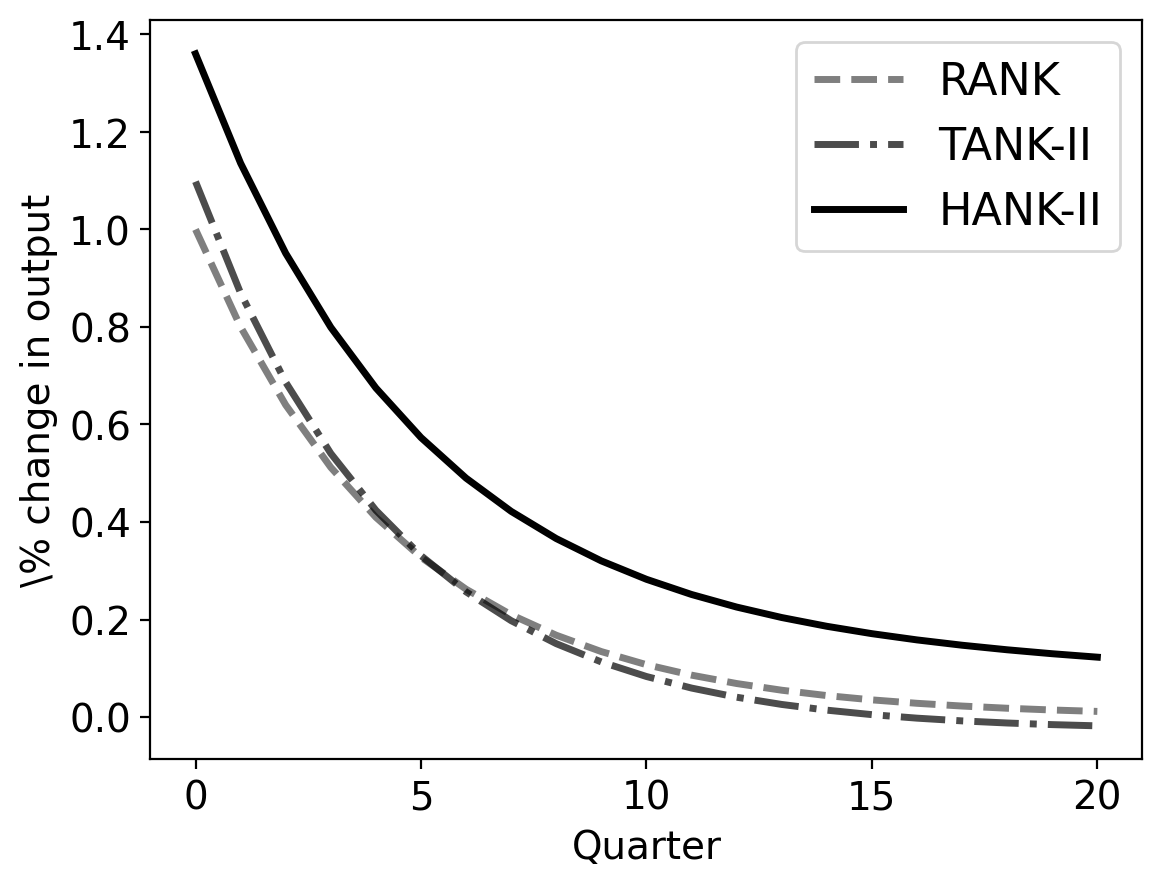

In [40]:
plt.plot(dG[:21], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5)
plt.plot(dY_TA2_def_long[:21], '-.', label='TANK-II', color='black', alpha=0.7, linewidth=2.5)
plt.plot(dY_HA2_def_long[:21], label='HANK-II', color='black', linewidth=2.5)
plt.ylabel('\% change in output')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs + 'deficit_persistent.pdf', bbox_inches='tight');

# 6. Werning neutral version of model

We continue calibrating so that the same fraction of households are constrained as in the baseline calibration. Let's quickly verify this:

In [41]:
data1 = ss2.internals['hh']
data2 = dg.ss_neutral.internals['hh']
np.vdot(data1['D'], (data1['a'] == data1['a_grid'][0])), np.vdot(data2['D'], (data2['a'] == data2['a_grid'][0]))

(0.2839902311005269, 0.28365688029812525)

In [42]:
ss = dg.ss_neutral
G = dg.model_neutral.solve_jacobian(ss, unknowns=['Y'], targets=['asset_mkt'],
                                    inputs=['r_ante', 'G', 'B'], outputs=['Y'], T=T)

### Monetary shock

In [43]:
dr = -0.25 * 0.5**np.arange(T)
dY_HA_neutral = (1+r) * G['Y', 'r_ante'] @ dr # scale by 1+r since this is proportional shock to gross rate
dY_RA = J_RA @ dr

Now we have to think about the TANK version of the model. We note that here, we'll have equal incidence of labor income, so that:

In [44]:
m_neutral = 1 / dg.mu * Xi_H * lambda_H # constant share of agg income going to HTM
share_u_ss = 1 - m_neutral # steady-state consumption share of non-HTM is just complement of this

and then evaluating our expression, it trivially agrees with the RA (the more nontrivial numerical result is the HA also agreeing perfectly):

In [45]:
dY_TA_neutral = 1/(1-m_neutral)*(share_u_ss*J_RA) @ dr

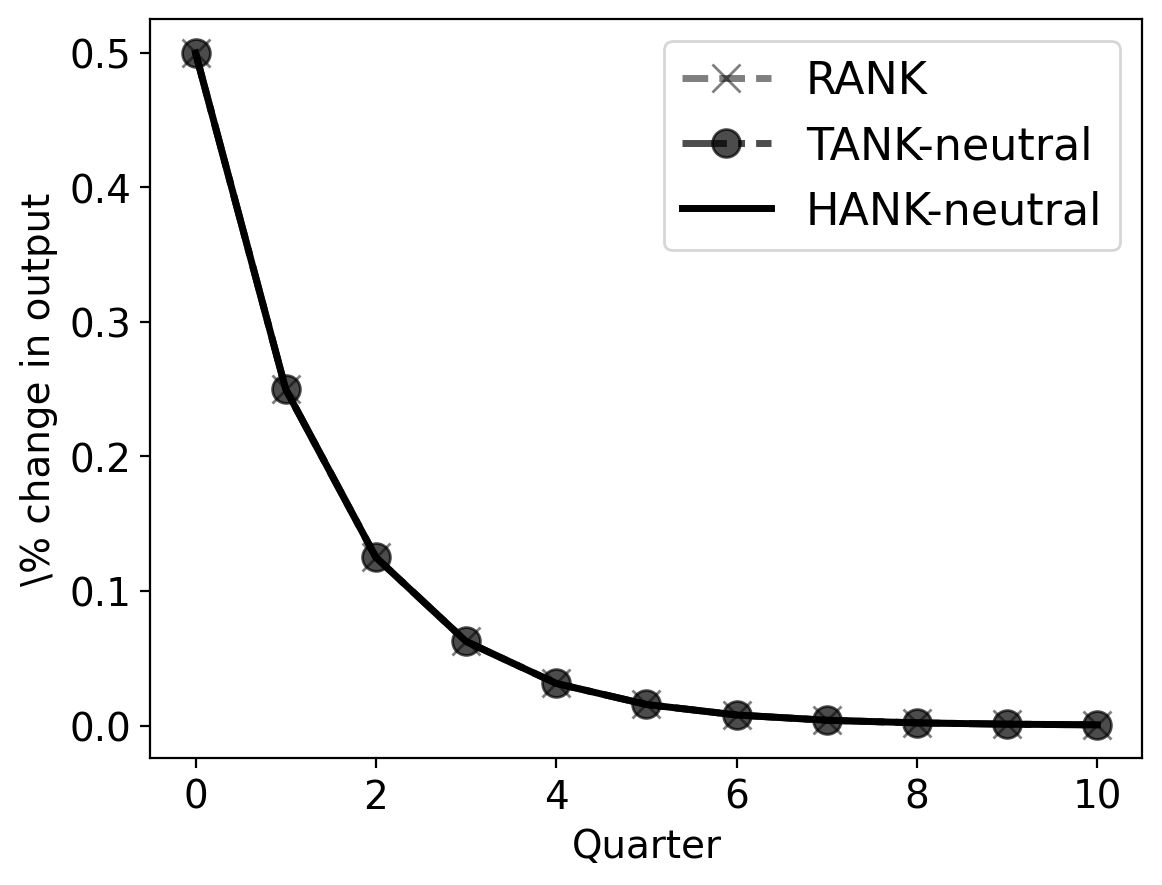

In [46]:
plt.plot(dY_RA[:11], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5, marker='x', markersize=10)
plt.plot(dY_TA_neutral[:11], '-.', label='TANK-neutral', color='black', alpha=0.7, linewidth=2.5, marker='o', markersize=10)
plt.plot(dY_HA_neutral[:11], label='HANK-neutral', color='black', linewidth=2.5)
plt.ylabel('\% change in output')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs + 'monetary_neutral.pdf', bbox_inches='tight');

### Fiscal shock

In [47]:
dB = dg.Bplan(dG, 0.975)
dT = dg.Tplan(dG, dB, r)
dY_HA_neutral = G['Y', 'B'] @ dB + G['Y', 'G'] @ dG
dY_TA_neutral = 1/(1-m_neutral)*(dG - m_neutral*dT)
dY_RA = dG

In [48]:
dY_RA[0], dY_TA_neutral[0], dY_HA_neutral[0] # impact multipliers

(1.0, 1.1945072483042958, 1.7720277416738544)

In [49]:
(q @ dY_RA)/(q @ dG), (q @ dY_TA_neutral)/(q @ dG), (q @ dY_HA_neutral)/(q @ dG) # cumulative multipliers

(1.0, 1.0000000598313183, 4.478875963226273)

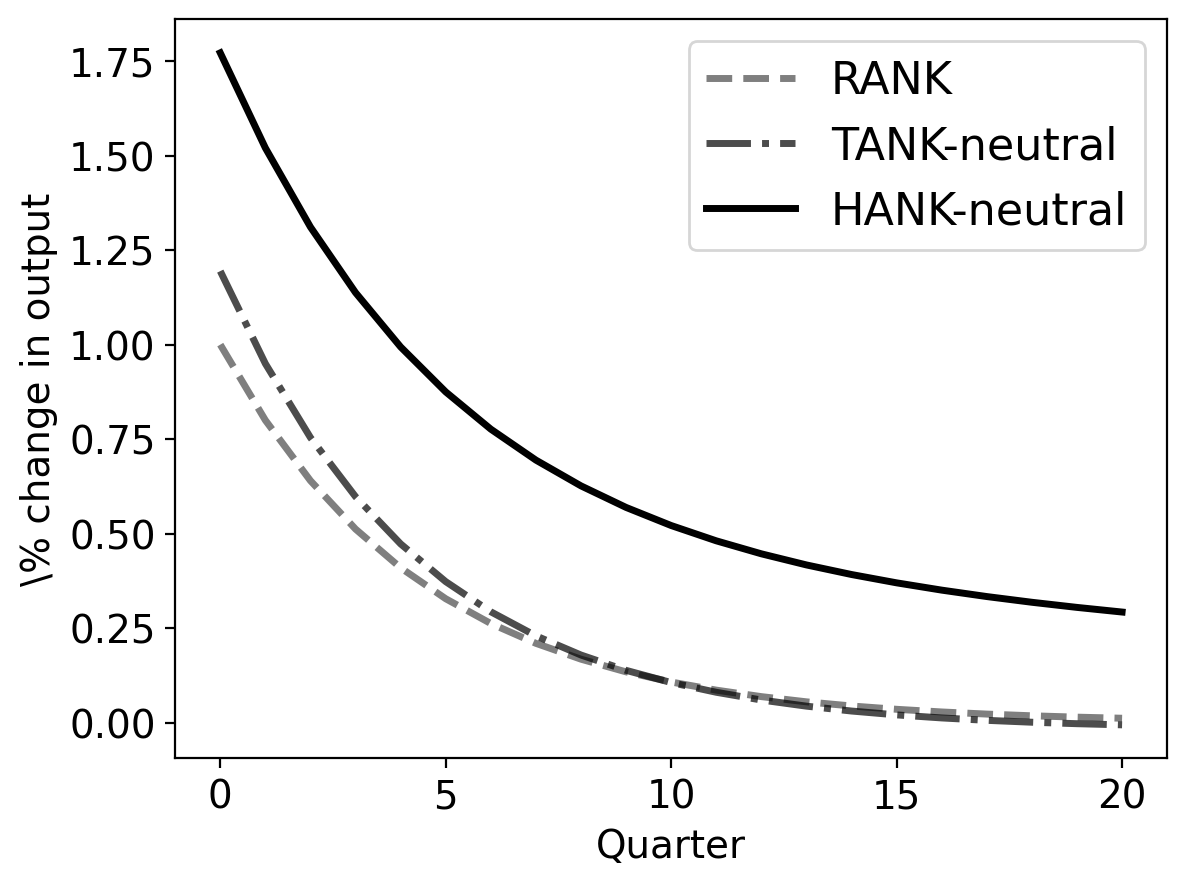

In [50]:
plt.plot(dG[:21], '--', label='RANK', color='black', alpha=0.5, linewidth=2.5)
plt.plot(dY_TA_neutral[:21], '-.', label='TANK-neutral', color='black', alpha=0.7, linewidth=2.5)
plt.plot(dY_HA_neutral[:21], label='HANK-neutral', color='black', linewidth=2.5)
plt.ylabel('\% change in output')
plt.legend()
plt.xlabel('Quarter')
if savefig: plt.savefig(graphs + 'deficit_neutral.pdf', bbox_inches='tight');